In [1]:
from numpy      import *
from physics    import * 
from TLA        import *
from structform import *

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('tableau10.mplstyle')

# Single Injection - Low Energy Spectrum

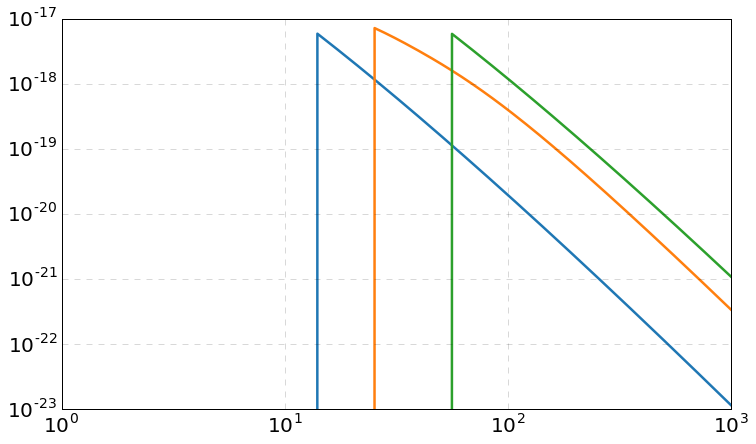

In [2]:
eng = logspace(0,3,num=200)
xsecH0  = photoionxsec(eng,'H0')
xsecHe0 = photoionxsec(eng,'He0')
xsecHe1 = photoionxsec(eng,'He1')

plt.plot(eng,xsecH0)
plt.plot(eng,xsecHe0)
plt.plot(eng,xsecHe1)
plt.xscale('log')
plt.yscale('log')

# Structure Formation

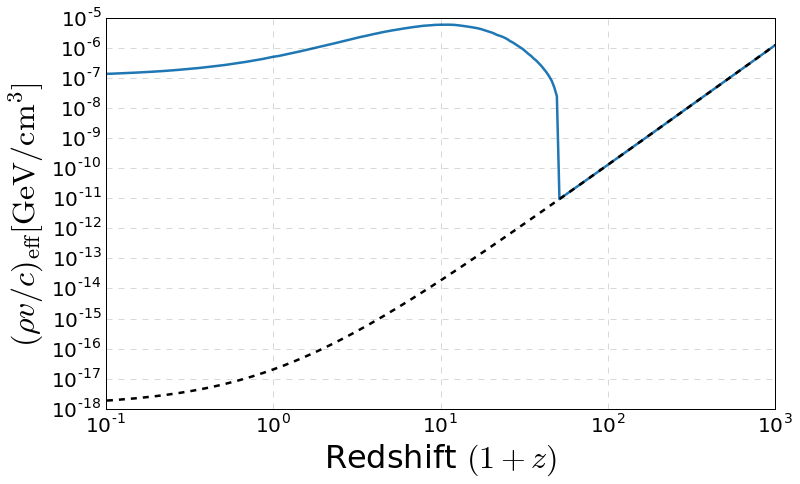

In [3]:
annChan = 'pWave'

structForm = getstructform(annChan,'rho_eff_Einasto_subs')

rsVec = logspace(0,3, num=200)

if annChan == 'sWave':
    yLabelPlot = r'$\rho_\mathrm{eff} [\mathrm{GeV/cm}^3]$'
elif annChan == 'pWave':
    yLabelPlot = r'$(\rho v/c)_\mathrm{eff} [\mathrm{GeV/cm}^3]$'
    
plt.figure(1)
plt.plot(rsVec-1,structForm(rsVec)*1e-9)
plt.plot(rsVec-1,rhoDM*rsVec**3*1e-9*sigma1DNorm(annChan,rsVec),linestyle='dashed',color='black')
plt.xlabel('Redshift '+r'$(1+z)$')
plt.ylabel(yLabelPlot)
plt.xlim([1e-1,1e3])
plt.xscale('log')
plt.yscale('log')

# Three-Level Atom Integration

This part of the code calls the integrator to perform the integration over ionization and thermal histories, given $f(z)$. 

In [4]:
def getfz():
    def fzHIon(rs,xe):
        return (1-xe)/3
    def fzHeIon(rs,xe):
        return 0
    def fzHLya(rs,xe):
        return (1-xe)/3
    def fzHeat(rs,xe):
        return (1+2*xe)/3
    return {'HIon':fzHIon, 'HeIon':fzHeIon, 'HLya':fzHLya, 'Heat':fzHeat}

def getinjrate(injType,injFac):
    def injrate(rs): 
        if injType == 'sWave':
            return injFac*(rs**6)
        elif injType == 'decay':
            return injFac*(rs**3)
    return injrate

initrs = 3000
initCond = [TCMB(initrs), 5]
rsVec = flipud(logspace(1,log10(initrs), num=2000))

ionThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e24),rsVec)
stdIonThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e24),rsVec)


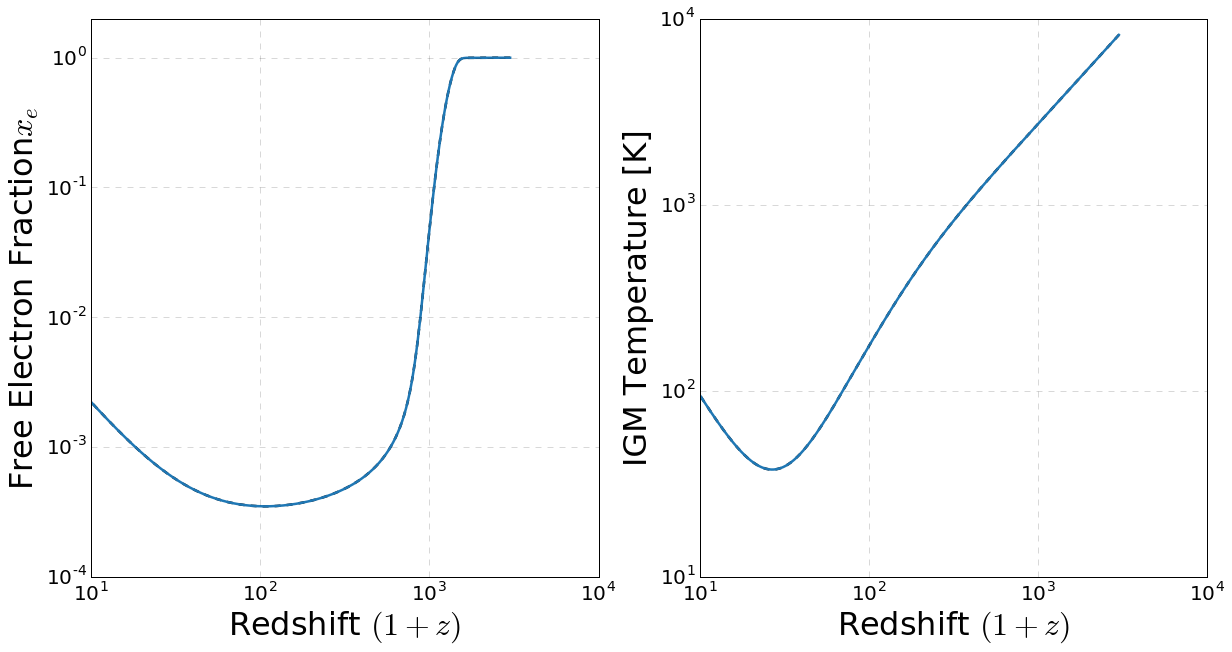

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(rsVec,0.5+0.5*tanh(stdIonThermHist[:,1]),linestyle='dashed',color='black')
plt.plot(rsVec,0.5+0.5*tanh(ionThermHist[:,1]))
plt.xlabel('Redshift '+r'$(1+z)$')
plt.ylabel('Free Electron Fraction'+r'$x_e$')
plt.ylim([1e-4,2])
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.plot(rsVec,stdIonThermHist[:,0]/kB,linestyle='dashed',color='black')
plt.plot(rsVec,ionThermHist[:,0]/kB)
plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.xscale('log')
plt.yscale('log')

plt.show()